In [ ]:
# Install required packages
!pip install pandas numpy scikit-learn joblib matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay

import joblib
sns.set_theme(style="ticks")
np.random.seed(42)


In [ ]:
# Load dataset
df = pd.read_csv("water Quality prediction data set.csv", sep=";")
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df = df.sort_values(["id", "date"])

# Extract date parts
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Pollutant columns
pollutants = ["O2", "NO3", "NO2", "SO4", "PO4", "CL"]

# Drop rows with missing pollutants
df = df.dropna(subset=pollutants)
df.reset_index(drop=True, inplace=True)
df.head()


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,year,month
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5,2000,2
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0,2000,5
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0,2000,9
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0,2000,12
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0,2001,3


In [ ]:
# Define ideal, standard, and weight values
ideal  = {"O2": 7.0, "NO3": 0.0, "NO2": 0.0, "SO4": 0.0, "PO4": 0.0, "CL": 0.0}
std    = {"O2": 14.6, "NO3": 45,  "NO2": 3,  "SO4": 250, "PO4": 0.5, "CL": 250}
weight = {"O2": 0.20, "NO3": 0.15, "NO2": 0.15, "SO4": 0.15, "PO4": 0.15, "CL": 0.20}

# Quality Index formula
def qi(c, p):
    return np.clip((c - ideal[p]) / (std[p] - ideal[p]) * 100, 0, 100)

def calc_wqi(row):
    scores = [qi(row[p], p) * weight[p] for p in pollutants]
    return sum(scores) / sum(weight.values())

df["WQI"] = df.apply(calc_wqi, axis=1)

# WQI class assignment
def wqi_class(wqi):
    if wqi <= 25:  return "Excellent"
    elif wqi <= 50: return "Good"
    elif wqi <= 75: return "Poor"
    else: return "Not Suitable"

df["WQI_Class"] = df["WQI"].apply(wqi_class)
df[["WQI", "WQI_Class"]].head()


,WQI,WQI_Class
0,60.259035,Poor
1,63.786667,Poor
2,54.017632,Poor
3,66.725526,Poor
4,62.678333,Poor


In [ ]:
# Features and Targets
X_raw = df[["id", "year"]]
y = df[pollutants].astype(float)

# One-hot encode 'id'
X_encoded = pd.get_dummies(X_raw, columns=["id"], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Optional: scale numeric values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
# Multi-output regression model
reg = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
)
reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = reg.predict(X_test_scaled)



In [ ]:
print("=== Per-Pollutant Regression Metrics ===")
for i, p in enumerate(pollutants):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{p:<4} | MSE: {mse:8.3f} | R²: {r2:6.3f}")


=== Per-Pollutant Regression Metrics ===
O2   | MSE:   22.145 | R²: -0.013
NO3  | MSE:   18.145 | R²:  0.516
NO2  | MSE:   10.891 | R²: -80.543
SO4  | MSE: 2485.519 | R²:  0.394
PO4  | MSE:    0.380 | R²:  0.331
CL   | MSE: 33844.762 | R²:  0.744


<Figure size 600x400 with 0 Axes>

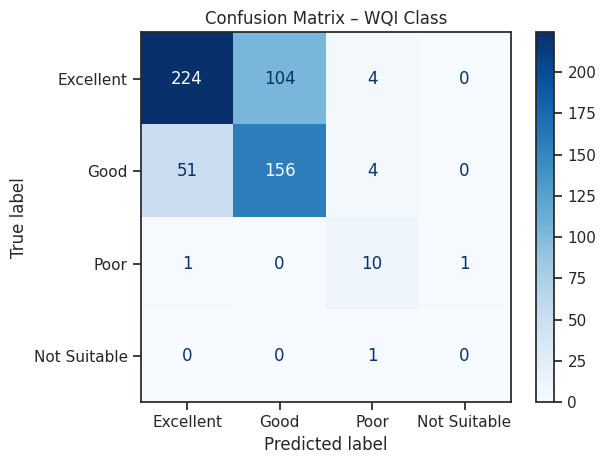

In [ ]:
# Actual WQI & Class
true_wqi = y_test.apply(lambda r: calc_wqi(r), axis=1)
true_class = true_wqi.apply(wqi_class)

# Predicted WQI & Class
pred_df = pd.DataFrame(y_pred, columns=pollutants)
pred_df["WQI"] = pred_df.apply(lambda r: calc_wqi(r), axis=1)
pred_class = pred_df["WQI"].apply(wqi_class)

# Confusion matrix
labels_order = ["Excellent", "Good", "Poor", "Not Suitable"]
cm = confusion_matrix(true_class, pred_class, labels=labels_order)

# Display
disp = ConfusionMatrixDisplay(cm, display_labels=labels_order)
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – WQI Class")
plt.tight_layout()
plt.show()


In [ ]:
def evaluate_random_samples(n=5):
    idx = random.sample(range(len(df)), n)
    rows = df.iloc[idx].reset_index(drop=True)

    X_small = pd.get_dummies(rows[["id", "year"]], columns=["id"])
    for col in X_encoded.columns:
        if col not in X_small:
            X_small[col] = 0
    X_small = X_small[X_encoded.columns]
    X_small_scaled = scaler.transform(X_small)

    preds = reg.predict(X_small_scaled)

    for i in range(n):
        print(f"\n------ SAMPLE {i+1} ------")
        print(f"Station: {rows.loc[i, 'id']} | Year: {rows.loc[i, 'year']}")
        for j, p in enumerate(pollutants):
            print(f"{p:<4}: Actual = {rows.loc[i,p]:.2f}  |  Predicted = {preds[i,j]:.2f}")

        true_wqi = calc_wqi(rows.loc[i, pollutants])
        pred_wqi = calc_wqi(dict(zip(pollutants, preds[i])))
        print(f"WQI  : Actual = {true_wqi:.2f} ({wqi_class(true_wqi)}) | Predicted = {pred_wqi:.2f} ({wqi_class(pred_wqi)})")

# Run it
evaluate_random_samples()



------ SAMPLE 1 ------
Station: 12 | Year: 2011
O2  : Actual = 4.40  |  Predicted = 6.79
NO3 : Actual = 1.28  |  Predicted = 1.78
NO2 : Actual = 0.53  |  Predicted = 0.18
SO4 : Actual = 18.80  |  Predicted = 36.80
PO4 : Actual = 0.56  |  Predicted = 0.70
CL  : Actual = 31.70  |  Predicted = 30.43
WQI  : Actual = 21.74 (Excellent) | Predicted = 21.14 (Excellent)

------ SAMPLE 2 ------
Station: 22 | Year: 2001
O2  : Actual = 18.40  |  Predicted = 13.36
NO3 : Actual = 10.90  |  Predicted = 5.49
NO2 : Actual = 0.01  |  Predicted = 0.02
SO4 : Actual = 88.30  |  Predicted = 82.13
PO4 : Actual = 0.25  |  Predicted = 0.26
CL  : Actual = 55.70  |  Predicted = 50.32
WQI  : Actual = 40.95 (Good) | Predicted = 35.32 (Good)

------ SAMPLE 3 ------
Station: 15 | Year: 2006
O2  : Actual = 5.90  |  Predicted = 9.34
NO3 : Actual = 1.00  |  Predicted = 1.82
NO2 : Actual = 0.03  |  Predicted = 0.05
SO4 : Actual = 41.10  |  Predicted = 35.60
PO4 : Actual = 0.18  |  Predicted = 0.21
CL  : Actual = 18.30 

In [ ]:
# Save model, scaler, and feature columns
joblib.dump(reg, "multi_rf_pollutant_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(X_encoded.columns.tolist(), "model_features.pkl")

print("✅ Model and supporting files saved.")


✅ Model and supporting files saved.
